In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from helper_functions import create_tensorboard_callback


In [2]:
tf.__version__

'2.7.0'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### What is Natural Language Processing (NLP) 

> Natural language processing, which evolved from computational linguistics, uses methods from various disciplines, such as computer science, artificial intelligence, linguistics, and data science, to enable computers to understand human language in both written and verbal forms. 
[IBM](https://www.ibm.com/blogs/watson/2020/11/nlp-vs-nlu-vs-nlg-the-differences-between-three-natural-language-processing-concepts/)

The usage of computers to have them the ability to understand both written and verbal forms in this case, text.
Types of NLP:
* Speech Recognition
* Machine Translation
* Sentiment Analysis
* Semantic Search


### What we're going to do?

Going to try and predict whether a tweet resembles a disaster tweet or not using NLP with various models and experimentations which would help in our classification.

### Loading and Parsing through the Dataset

Dataset Taken from [Kaggle's Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started)

In [4]:
test_df = pd.read_csv('./NLP-NLU-Files/Dataset/Disaster-Tweets/test.csv')
train_df = pd.read_csv('./NLP-NLU-Files/Dataset/Disaster-Tweets/train.csv')

#### Visualizing Tweets

In [5]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [6]:
train_df_shuffled = train_df.sample(frac=1).reset_index(drop=True)

In [7]:
### Get a random sample set

sample_set = train_df_shuffled[['text', 'target']]

random_n = random.randint(0, len(sample_set)-5)

for row in sample_set[random_n: random_n+5].itertuples():
    _, text, target = row
    print(f'Target: {target}', '(real_disaster)' if target > 0 else '(not real disaster)')
    print(f'Text:\n{text}\n')
    print("---\n")

Target: 1 (real_disaster)
Text:
Top insurer blasts lack of Australian Govt action on disaster mitigation http://t.co/sDgOUtWNtb via @smh

---

Target: 1 (real_disaster)
Text:
Kach was a group to which belonged Baruch Goldstein a mass murderer who in 1994 shot and killed 29 PalestinianÛ_ http://t.co/bXGNQ57xvb

---

Target: 0 (not real disaster)
Text:
My dogÛªs just blown his kennel up ÛÒ Bloody Yorkshire Terrorist

---

Target: 0 (not real disaster)
Text:
Ercjmnea: Breaking news! Unconfirmed! I just heard a loud bang nearby. in what appears to be a blast of wind from my neighbour's ass.

---

Target: 0 (not real disaster)
Text:
Simmering beneath #NHL good times the league's own concussion issues @PioneerPress

http://t.co/zl7FhUCxHL

---



### Splitting the Train Data by Train-Test-Split

In [8]:
X = train_df_shuffled['text'].to_numpy()
y = train_df_shuffled['target'].to_numpy()

In [9]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42
)

In [10]:
len(train_sentences),len(train_labels), len(val_sentences),len(val_labels)

(6851, 6851, 762, 762)

In [11]:
for i in range(0,5):
    print(f'{train_labels[i]}', 'real disaster' if train_labels[i] > 0 else 'not real disaster', 
          f'\n{train_sentences[i]}\n')

1 real disaster 
Watch our video of Wendell Berry speaking about the BP oil spill in the Gulf of Mexico.

ItÛªs the birthday... http://t.co/tN1aX1xMBB

0 not real disaster 
my vibrator shaped vape done busted

0 not real disaster 
There is this old lady rockin out to death metal in her sedan downtown smoking a cigarette. I found my real mom.

1 real disaster 
This why BSF Jawans died Fidayeen has AKs and they bloody #INSAS! INSAS rifles not to blame for soldiers' deaths MoD http://t.co/1Lk1EQwyUW

1 real disaster 
the pastor was not in the scene of the accident......who was the owner of the range rover ?



### Building Blocks and How it Works

---
**Tokenization** is straight up mapping the words without any weight/values, just regular numerical encoding  
  
* **Word-Level Tokenization** - maps the whole text and maps each word; thus it(the word) is considered a token. (e.q. one-hot encoding)
* **Character-Level Tokenization** - maps the whole text but focuses on each letter from 1 - 26; thus it(each letter) is considered a token.  
* **Sub-word Tokenization** - takes the syllables of a word and tokenizes it 

**Embedding** uses vector weights that can be learned as out network trains. i.e. individual letters in a word on how each letter can be of importance to create that word.

---

🔑 **Takeaways**  
  
**Process**  

* **Build a Text Vectorizer**  
    * **`max_vocab_length`** - 1000  
    * **`max_length`** - taken from the length of each word in a sentence, summed together  
and divided by the total amount of train_sentences  `sum([len(i.split()) for i in train_]) / len(train_)`
 

* **Build a Embedding Layer**
    * **`input_dim`** - same as `max_vocab_length`  
    * **`output_dim`** - any number divisible by `8`  
    * **`input_length`** - same as `max_length`  
    
     
> You must vectorize your text before feeding it to the embedding layer

In [12]:
sum([len(i.split()) for i in train_sentences])/len(train_sentences)

14.898700919573784

In [13]:
max_vocab_length = 10000
max_length = 15

#### Token Vectorizer

In [14]:
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_vocab_length,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=max_length,
    pad_to_max_tokens=True
)

In [15]:
text_vectorizer.adapt(train_sentences)

In [16]:
random_sentence = random.choice(train_sentences)
print(f'Original test:\n{random_sentence}')
text_vectorizer([random_sentence])

Original test:
@Dr_Baseball41 @GrantTamane8 @DrewWTaylor @Dtop77   On the Christie Hillside: Game 4: Pandemonium at the Pits. http://t.co/Lq4lXGS2xU


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1,    1,    1,    1,   11,    2, 3989,    1,  457,  170,  507,
          16,    2, 4876,    1]], dtype=int64)>

In [17]:
words_in_vocab = text_vectorizer.get_vocabulary()
words_in_vocab[:5],words_in_vocab[-5:]

(['', '[UNK]', 'the', 'a', 'in'],
 ['particulatebreak',
  'particular',
  'participating',
  'participate',
  'partially'])

#### Embedding Layer

In [18]:
embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length,
                                      output_dim=128,
                                      input_length=max_length,
                                      embeddings_initializer='uniform'
                                     )
embedding

#### Making Use of Both

In [19]:
print(f'Original test:\n{random_sentence}')
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original test:
@Dr_Baseball41 @GrantTamane8 @DrewWTaylor @Dtop77   On the Christie Hillside: Game 4: Pandemonium at the Pits. http://t.co/Lq4lXGS2xU


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02663603,  0.04215778, -0.04130263, ...,  0.02177149,
          0.01937262, -0.01267599],
        [-0.02663603,  0.04215778, -0.04130263, ...,  0.02177149,
          0.01937262, -0.01267599],
        [-0.02663603,  0.04215778, -0.04130263, ...,  0.02177149,
          0.01937262, -0.01267599],
        ...,
        [ 0.01269392, -0.04423671, -0.02489638, ...,  0.00839049,
         -0.00667229, -0.01199985],
        [-0.03160869,  0.02961725,  0.02289288, ...,  0.02177877,
         -0.01554841, -0.02680509],
        [-0.02663603,  0.04215778, -0.04130263, ...,  0.02177149,
          0.01937262, -0.01267599]]], dtype=float32)>

In [20]:
sample_embed[0][0], random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.02663603,  0.04215778, -0.04130263,  0.02813853, -0.04228611,
        -0.02102394, -0.03763955, -0.00325446,  0.04369882, -0.01045295,
        -0.00645547, -0.02141308,  0.00230439, -0.04131854, -0.02733638,
        -0.0304315 ,  0.03998655, -0.01546242, -0.0189464 ,  0.02773705,
         0.0222786 , -0.04274793,  0.00175892,  0.01587627, -0.0108791 ,
         0.03345918,  0.02933902,  0.04348297,  0.00835849, -0.00438888,
        -0.04264542, -0.03275536,  0.01354906,  0.03139069, -0.01637368,
        -0.0369323 ,  0.02171135, -0.01567793, -0.01576931,  0.03514552,
         0.02152257, -0.02333226,  0.0491165 , -0.04814294,  0.0175474 ,
         0.01728264, -0.02080221, -0.02762713,  0.02928697, -0.03164982,
         0.01407285,  0.03718417, -0.04035687, -0.00400531,  0.04687184,
         0.02590038,  0.04608523, -0.01913813, -0.04385716, -0.01580562,
         0.01857604, -0.01025231,  0.01925609,  0.0412941 , -0.01933014,
  

### Model Building

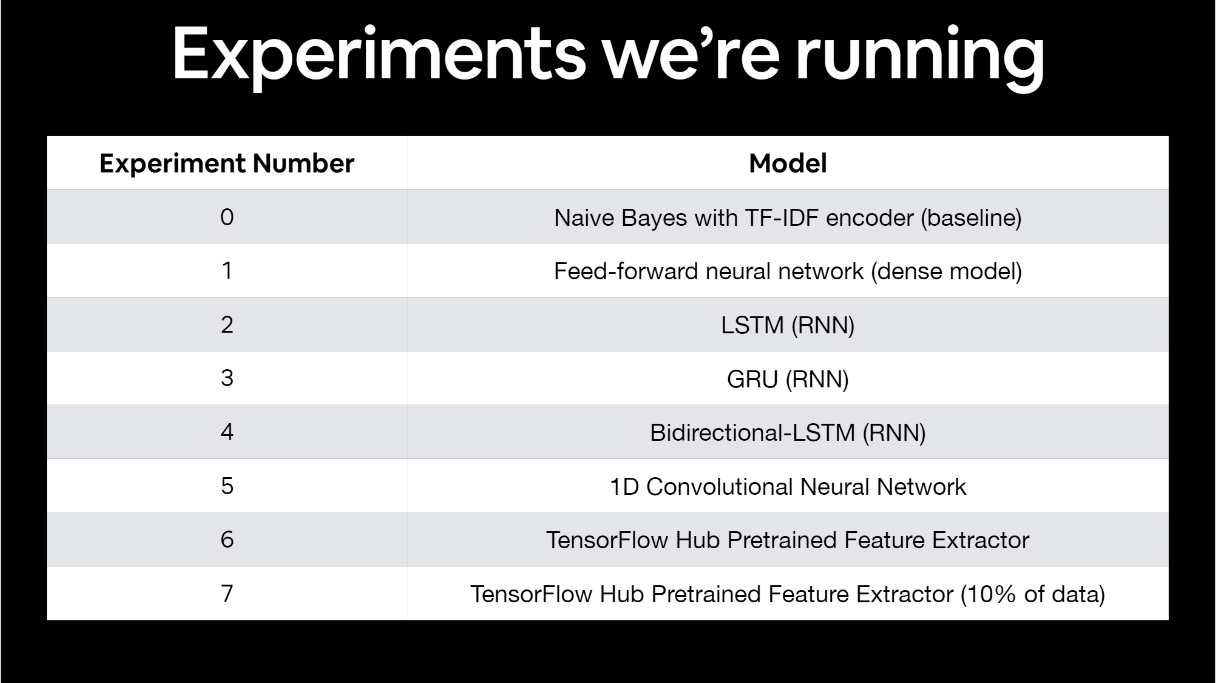

Image taken from [MDBourke's Slide for NLP](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/slides/08_natural_language_processing_in_tensorflow.pdf)

**Model 0**: Naive Bayes (Baseline)  
**Model 1**: Feed-forward neural network (Dense Model)  
**Model 2**: LSTM model (RNN)  
**Model 3**: GRU Model (RNN)  
**Model 4**: Bidirectional-LTSM Model (RNN)  
**Model 5**: 1D Convolutional Neural Network (CNN)  
**Model 6**: TensorFlow Hub Pretrained Feature Extration (Transfer Learning)  
**Model 7**: Same as Model 6 with 10% of training data  

#### Functions

In [21]:
def evaluate_text_preds(y_preds, y_true, y_true_sentences):
    '''
    outputs a list of prediction, true labels, and its sentence
    
    Parameters
    -------
    y_preds - predictions from the model
    y_true - true labels from test split
    y_true_sentences - sentence of the true label
    '''
    pred_results = []
    for i in range(0, len(y_preds)):
        if y_preds[i] == y_true[i]:
            #print('correct prediction')
            pred_results.append('Correct Prediction')
        else:
            #print('wrong prediction')
            pred_results.append('Wrong Prediction')
            
    for i in range(0, len(pred_results)):
        print('---\n')
        print(f'{pred_results[i]} \n'
              f'Prediction: {y_preds[i]} | True Label: {y_true[i]}\n\n'
              f'{y_true_sentences[i]}\n')
    


In [22]:
def evaluate_model_results(y_preds, y_true):
    '''
    returns a list of model evaluation results
    
    Paremeters
    -------
    y_preds - predictions from the model
    y_true - true labels from test split
    '''
    model_accuracy = accuracy_score(y_true, y_preds)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_preds, average='weighted')
    
    model_results = {'accuracy' : model_accuracy,
                     'precision' : model_precision,
                     'recall': model_recall,
                     'f1-score': model_f1}
    return model_results

#### Model 0 - Scikit-Learn Naive Bayes

For our baseline model we're going to use Sklearn's NaiveBayes' MultinomialNB

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
], verbose=True)

model_0.fit(train_sentences, train_labels)

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())],
         verbose=True)

In [24]:
baseline_score = model_0.score(val_sentences, val_labels)
baseline_score

0.7952755905511811

In [25]:
baseline_preds = model_0.predict(val_sentences)

In [26]:
val_labels[:10], baseline_preds[:10]

(array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int64),
 array([1, 0, 1, 1, 0, 0, 1, 0, 1, 0], dtype=int64))

In [27]:
evaluate_text_preds(baseline_preds[:5], val_labels[:5], val_sentences[:5])

---

Correct Prediction 
Prediction: 1 | True Label: 1

@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers?@VP

---

Wrong Prediction 
Prediction: 0 | True Label: 1

As firefighters make gains on #RockyFire Jerry Brown is heading to the area to meet with first responders tomorrow morning

---

Correct Prediction 
Prediction: 1 | True Label: 1

Relief train carrying survivors of the derailed Janta Express reaches Mumbai via @firstpostin http://t.co/CZNXHuTASX

---

Correct Prediction 
Prediction: 1 | True Label: 1

U.S. in record hurricane drought http://t.co/8JvQI9UspL

---

Correct Prediction 
Prediction: 0 | True Label: 0

'It hasn't collapsed because the Greek people are still being played for as fools by Tsipras he costÛ_' ÛÓ WallyBaiter http://t.co/gbRNuLp3fH



In [28]:
model_0_results = evaluate_model_results(val_labels, baseline_preds)
model_0_results

{'accuracy': 0.7952755905511811,
 'precision': 0.8415284216216306,
 'recall': 0.7952755905511811,
 'f1-score': 0.8032113838163847}

#### Model 1 - Feed-Forward Neural Network (Dense Model)

Model 1 will use our base neural network workflow and see if it works well

In [29]:
# Building Model 1
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_layer')
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
#x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [30]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [31]:
tensorboard_dir='./NLP-NLU-Files/model_logs'

In [32]:
model_1.fit(x=train_sentences,
            y=train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(dir_name=tensorboard_dir, 
                                                   experiment_name='model_1_dense')]
           )

Saving Tensorboard logfiles to ./NLP-NLU-Files/model_logs/logs/fits/model_1_dense/20211123-140457
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.6113 - accuracy: 0.6957 - val_loss: 0.5471 - val_accuracy: 0.7480
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.4409 - accuracy: 0.8183 - val_loss: 0.4900 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3456 - accuracy: 0.8631 - val_loss: 0.4813 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2810 - accuracy: 0.8930 - val_loss: 0.4967 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2340 - accuracy: 0.9161 - val_loss: 0.5277 - val_accuracy: 0.7664


In [33]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.5277 - accuracy: 0.7664


[0.5277214646339417, 0.7664042115211487]

In [34]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [35]:
model_1_pred_probs[:10]

array([[0.93515325],
       [0.7649866 ],
       [0.99578166],
       [0.9427091 ],
       [0.16003609],
       [0.5501643 ],
       [0.99985754],
       [0.5140318 ],
       [0.97406095],
       [0.03720224]], dtype=float32)

In [36]:
# convert to 1 & 0
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds ;

In [37]:
model_1_results = evaluate_model_results(model_1_preds, val_labels)
model_1_results

{'accuracy': 0.7664041994750657,
 'precision': 0.7671231853399584,
 'recall': 0.7664041994750657,
 'f1-score': 0.7636062660161435}

In [38]:
model_0_results

{'accuracy': 0.7952755905511811,
 'precision': 0.8415284216216306,
 'recall': 0.7952755905511811,
 'f1-score': 0.8032113838163847}

In [39]:
embed_weights = model_1.get_layer('embedding').get_weights()[0]
embed_weights

array([[-0.02028726,  0.03857418,  0.00800266, ...,  0.06278965,
         0.03125695,  0.02130689],
       [-0.01284005,  0.05669284, -0.05635321, ...,  0.03789533,
         0.03545998, -0.0267706 ],
       [ 0.04560126, -0.00629227, -0.05806281, ...,  0.04111937,
         0.026429  , -0.04425455],
       ...,
       [-0.05875651, -0.08157318,  0.08767566, ..., -0.05762956,
        -0.02960389,  0.05735482],
       [-0.04554181, -0.08193896,  0.06003559, ..., -0.01170183,
        -0.09819179,  0.01251616],
       [ 0.01825975,  0.05269608, -0.08643276, ...,  0.0513827 ,
         0.01259203, -0.10641724]], dtype=float32)

In [40]:
import io
out_v = io.open('./NLP-NLU-Files/vectors_and_metadata/vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('./NLP-NLU-Files/vectors_and_metadata/metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

#### Model 2 - RNN LSTM (Long Short Term Memory)
LSTM - Long Short Term Memory, its like logic gates where it stores 1s and 0s.
> see it this way, when you feed it an training set, it learns its weights and uses those patterns to predict the next word, it can just store depending on how the value of the weight performs based on the tanh activation function.

[Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)](https://www.youtube.com/watch?v=WCUNPb-5EYI&t=297s&ab_channel=BrandonRohrer)

In [41]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.LSTM(units=64, return_sequences=True)(x)
x = tf.keras.layers.LSTM(64)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [42]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                      

In [43]:
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [44]:
model_2.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences,val_labels),
            callbacks=[create_tensorboard_callback(dir_name=tensorboard_dir,
                                                   experiment_name='model_2_rnn')])

Saving Tensorboard logfiles to ./NLP-NLU-Files/model_logs/logs/fits/model_2_rnn/20211123-140507
Epoch 1/5
215/215 [==============================] - 8s 15ms/step - loss: 0.2218 - accuracy: 0.9180 - val_loss: 0.6431 - val_accuracy: 0.7493
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1542 - accuracy: 0.9384 - val_loss: 0.7661 - val_accuracy: 0.7454
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1249 - accuracy: 0.9537 - val_loss: 0.9382 - val_accuracy: 0.7218
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1019 - accuracy: 0.9588 - val_loss: 1.0963 - val_accuracy: 0.7283
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0792 - accuracy: 0.9663 - val_loss: 1.2247 - val_accuracy: 0.7362


In [45]:
model_2.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 5ms/step - loss: 1.2247 - accuracy: 0.7362


[1.2246737480163574, 0.7362204790115356]

In [46]:
model_2_rnn_pred_probs = model_2.predict(val_sentences)
model_2_rnn_pred_probs[:5]

array([[9.9994850e-01],
       [9.9636972e-01],
       [9.9997365e-01],
       [9.9967301e-01],
       [2.1039562e-04]], dtype=float32)

In [47]:
model_2_preds = tf.squeeze(tf.round(model_2_rnn_pred_probs))

In [48]:
model_2_results = evaluate_model_results(model_2_preds, val_labels)
model_2_results

{'accuracy': 0.7362204724409449,
 'precision': 0.7351897370962818,
 'recall': 0.7362204724409449,
 'f1-score': 0.7352416082675398}

#### Model 3 - RNN GRU (Gated Recurrent Unit)

> similar to the LSTM Function but has a forget gate, with a tanh function on whether it stores or forget.

also cited in
[Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)](https://www.youtube.com/watch?v=WCUNPb-5EYI&t=297s&ab_channel=BrandonRohrer) 

In [49]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GRU(64)(x)
#x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
#x = tf.keras.layers.GRU(64)(x)
#x = tf.keras.layers.Dense(1, activation='sigmo')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_3 = tf.keras.models.Model(inputs, outputs)

model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [50]:
model_3.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(dir_name=tensorboard_dir,
                                                   experiment_name='model_3_rnn')])

Saving Tensorboard logfiles to ./NLP-NLU-Files/model_logs/logs/fits/model_3_rnn/20211123-140526
Epoch 1/5
215/215 [==============================] - 5s 11ms/step - loss: 0.1550 - accuracy: 0.9368 - val_loss: 0.8193 - val_accuracy: 0.7362
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0838 - accuracy: 0.9676 - val_loss: 1.0649 - val_accuracy: 0.7205
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0724 - accuracy: 0.9704 - val_loss: 1.0427 - val_accuracy: 0.7139
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0632 - accuracy: 0.9718 - val_loss: 1.0623 - val_accuracy: 0.7165
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0547 - accuracy: 0.9761 - val_loss: 1.5278 - val_accuracy: 0.7073


In [51]:
model_3_preds = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_preds))

In [52]:
model_3_results = evaluate_model_results(model_3_preds, val_labels)
model_3_results

{'accuracy': 0.7073490813648294,
 'precision': 0.7058307239028039,
 'recall': 0.7073490813648294,
 'f1-score': 0.7056892126634301}

#### Model 4 - RNN Bidirectional LSTM

> Bidirectional LSTM is basically an LSTM the flows both ways, right to left. unlike it's natural algorithm it only reads data from left to right, whereas BLSTM flows from left to right, and also right to left increasing the output shape by twice its original/set shape.

In [53]:
from tensorflow.keras.layers import LSTM

In [54]:
forward_layer = tf.keras.layers.LSTM(64, return_sequences=True)
backward_layer = tf.keras.layers.GRU(64)

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
#x = tf.keras.layers.Bidirectional(forward_layer)(x)
x = tf.keras.layers.Bidirectional(LSTM(64))(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_4 = tf.keras.models.Model(inputs, outputs)

model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [55]:
model_4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-tra

In [56]:
model_4.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(dir_name=tensorboard_dir,
                                                   experiment_name='model_4_rnn')])

Saving Tensorboard logfiles to ./NLP-NLU-Files/model_logs/logs/fits/model_4_rnn/20211123-140538
Epoch 1/5
215/215 [==============================] - 7s 15ms/step - loss: 0.1021 - accuracy: 0.9705 - val_loss: 1.2444 - val_accuracy: 0.7178
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0515 - accuracy: 0.9761 - val_loss: 1.4246 - val_accuracy: 0.7257
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0425 - accuracy: 0.9783 - val_loss: 1.5625 - val_accuracy: 0.7205
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0427 - accuracy: 0.9797 - val_loss: 1.4998 - val_accuracy: 0.7034
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0371 - accuracy: 0.9793 - val_loss: 1.8331 - val_accuracy: 0.7297


In [57]:
model_4_preds = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_preds))

In [58]:
model_4_results = evaluate_model_results(model_4_preds, val_labels)

> goes both ways thats why its 128

#### Model 5 - CNN (1D Conv. Neural Networks)

In [59]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(64, 5, activation='relu', strides=1, padding='valid')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_5 = tf.keras.models.Model(inputs, outputs)

model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [60]:
model_5.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 1)                 65  

In [61]:
model_5.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(dir_name=tensorboard_dir,
                                                   experiment_name='model_5_cnn')])

Saving Tensorboard logfiles to ./NLP-NLU-Files/model_logs/logs/fits/model_5_cnn/20211123-140555
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.1215 - accuracy: 0.9593 - val_loss: 1.0623 - val_accuracy: 0.7218
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0745 - accuracy: 0.9707 - val_loss: 1.1792 - val_accuracy: 0.7205
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0596 - accuracy: 0.9764 - val_loss: 1.3133 - val_accuracy: 0.7139
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0529 - accuracy: 0.9768 - val_loss: 1.3839 - val_accuracy: 0.7270
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0485 - accuracy: 0.9796 - val_loss: 1.4279 - val_accuracy: 0.7152


In [62]:
model_5_preds = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_preds))

In [63]:
model_5_results = evaluate_model_results(model_5_preds, val_labels)
model_5_results

{'accuracy': 0.7152230971128609,
 'precision': 0.7140863750394281,
 'recall': 0.7152230971128609,
 'f1-score': 0.7142953089110089}

> Make padding same and strides to 1, strides would mean each step per word within the sentence

#### Model 6 - Transfer Learning

using a pretrained sentence encoder from tensorflow-hub

In [64]:
#module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       input_shape=[],
                                       dtype=tf.string,
                                       trainable=False,
                                       name='USE')

In [87]:
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
], name='Model_6_USE')

model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [88]:
model_6.summary()

Model: "Model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [89]:
history_model_6 = model_6.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(dir_name=tensorboard_dir,
                                                   experiment_name='model_6_transferlearning')])

Saving Tensorboard logfiles to ./NLP-NLU-Files/model_logs/logs/fits/model_6_transferlearning/20211123-140823
Epoch 1/5
215/215 [==============================] - 6s 18ms/step - loss: 0.4810 - accuracy: 0.7901 - val_loss: 0.4729 - val_accuracy: 0.7913
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4048 - accuracy: 0.8210 - val_loss: 0.4699 - val_accuracy: 0.7979
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3885 - accuracy: 0.8281 - val_loss: 0.4755 - val_accuracy: 0.8031
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3803 - accuracy: 0.8345 - val_loss: 0.4725 - val_accuracy: 0.8045
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3688 - accuracy: 0.8409 - val_loss: 0.4711 - val_accuracy: 0.8045


In [90]:
model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 15ms/step - loss: 0.4711 - accuracy: 0.8045


[0.47109031677246094, 0.8044619560241699]

In [91]:
model_6_preds = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_preds))

In [92]:
model_6_results = evaluate_model_results(model_6_preds, val_labels)
model_6_results

{'accuracy': 0.8044619422572179,
 'precision': 0.8076205528769484,
 'recall': 0.8044619422572179,
 'f1-score': 0.8016339883780326}

#### Model 7 - Transfer Learning 10% Data

In [93]:
train_10_percent_split = int(0.11 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

pd.Series(np.array(train_labels_10_percent)).value_counts()

0    420
1    333
dtype: int64

In [94]:
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [95]:
model_7 = tf.keras.models.clone_model(model_6)

model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_7.fit(train_sentences_10_percent,
            train_labels_10_percent,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(dir_name=tensorboard_dir,
                                                   experiment_name='model_7_10_percent')]
            )

Saving Tensorboard logfiles to ./NLP-NLU-Files/model_logs/logs/fits/model_7_10_percent/20211123-140856
Epoch 1/5
24/24 [==============================] - 5s 66ms/step - loss: 0.6606 - accuracy: 0.7198 - val_loss: 0.6247 - val_accuracy: 0.7559
Epoch 2/5
24/24 [==============================] - 1s 35ms/step - loss: 0.5591 - accuracy: 0.8141 - val_loss: 0.5437 - val_accuracy: 0.7690
Epoch 3/5
24/24 [==============================] - 1s 31ms/step - loss: 0.4694 - accuracy: 0.8260 - val_loss: 0.5003 - val_accuracy: 0.7677
Epoch 4/5
24/24 [==============================] - 1s 36ms/step - loss: 0.4121 - accuracy: 0.8393 - val_loss: 0.4891 - val_accuracy: 0.7638
Epoch 5/5
24/24 [==============================] - 1s 33ms/step - loss: 0.3811 - accuracy: 0.8459 - val_loss: 0.4910 - val_accuracy: 0.7572


In [96]:
model_7_preds = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_preds))

In [97]:
model_7_results = evaluate_model_results(model_7_preds, val_labels)
model_7_results

{'accuracy': 0.7572178477690289,
 'precision': 0.7564426380031116,
 'recall': 0.7572178477690289,
 'f1-score': 0.7565332575067626}

### Comparing Results

In [98]:
all_model_results = pd.DataFrame({
    '0_baseline' : model_0_results,
    '1_dense_layer' : model_1_results,
    '2_LSTM' : model_2_results,
    '3_GRU' : model_3_results,
    '4_bidirectional' : model_4_results,
    '5_conv1d' : model_5_results,
    '6_tf_hub_use_encoder' : model_6_results,
    '7_tf_hub_use_encoder_10_percent' : model_7_results,
})

In [99]:
all_model_results = all_model_results.transpose()

In [100]:
all_model_results.columns

Index(['accuracy', 'precision', 'recall', 'f1-score'], dtype='object')

In [101]:
for column in all_model_results.columns:
    all_model_results[column] = all_model_results[column]*100

In [102]:
all_model_results

,accuracy,precision,recall,f1-score
0_baseline,79.527559,84.152842,79.527559,80.321138
1_dense_layer,76.640420,76.712319,76.640420,76.360627
2_LSTM,73.622047,73.518974,73.622047,73.524161
3_GRU,70.734908,70.583072,70.734908,70.568921
4_bidirectional,72.965879,73.373171,72.965879,72.265034
5_conv1d,71.522310,71.408638,71.522310,71.429531
6_tf_hub_use_encoder,80.446194,80.762055,80.446194,80.163399
7_tf_hub_use_encoder_10_percent,75.721785,75.644264,75.721785,75.653326


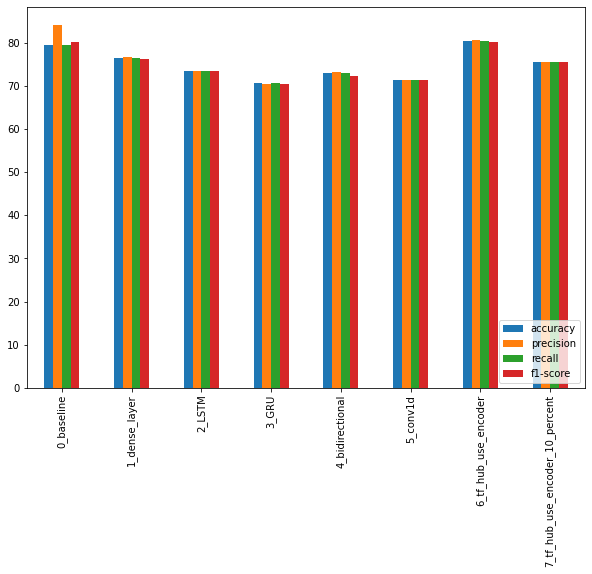

In [103]:
all_model_results.plot(kind='bar', figsize=(10,7)).legend(loc='lower right');


In [83]:
%load_ext tensorboard
%tensorboard --logdir='./NLP-NLU-Files/model_logs/'

Reusing TensorBoard on port 6006 (pid 33168), started 0:02:49 ago. (Use '!kill 33168' to kill it.)

### Plotting the Most Wrong predictions

In [184]:
model_6_pred_proba = model_6.predict(val_sentences)
model_6_pred_proba = tf.squeeze(model_6_pred_proba)


In [190]:
most_wrong_preds = pd.DataFrame({
    'sentence': val_sentences,
    'prediction': model_6_preds,
    'true_label': val_labels,
    'pred_proba': model_6_pred_proba
})
most_wrong_preds = most_wrong_preds[most_wrong_preds['prediction'] != most_wrong_preds['true_label']]
most_wrong_preds = most_wrong_preds.sort_values(by='pred_proba', ascending=False).reset_index(drop=True)
most_wrong_preds[:5]

,sentence,prediction,true_label,pred_proba
0,Episcopal priests on road trip with interracia...,1.0,0,0.969841
1,We should all have a fire safety plan. RT @Mat...,1.0,0,0.938825
2,#stlouis #caraccidentlawyer Speeding Among Top...,1.0,0,0.910145
3,San Jose Mercury: Governor Brown allows parole...,1.0,0,0.903883
4,@mickinyman @TheAtlantic That or they might be...,1.0,0,0.899057


In [203]:
for i in range(0, 5):
    print(f'Probability: {most_wrong_preds.pred_proba[i]}, Prediction: {most_wrong_preds.prediction[i]} | True:{most_wrong_preds.true_label[i]}\n',
          f'{most_wrong_preds.sentence[i]}',
         '\n\n------\n')

Probability: 0.9698408246040344, Prediction: 1.0 | True:0
 Episcopal priests on road trip with interracial family shares harrowing story of police harassment http://t.co/RG4JIsHyBs via @dailykos 

------

Probability: 0.9388247132301331, Prediction: 1.0 | True:0
 We should all have a fire safety plan. RT @Matt_Kroschel: MOCK WILDFIRE near #Vail as agencies prepare for the worst. http://t.co/SWwyLRk0fv 

------

Probability: 0.9101449847221375, Prediction: 1.0 | True:0
 #stlouis #caraccidentlawyer Speeding Among Top Causes of Teen Accidents https://t.co/k4zoMOF319 https://t.co/S2kXVM0cBA Car Accident teeÛ_ 

------

Probability: 0.9038833379745483, Prediction: 1.0 | True:0
 San Jose Mercury: Governor Brown allows parole for California school bus hijacker  http://t.co/GpCeCp9kHv 

------

Probability: 0.8990566730499268, Prediction: 1.0 | True:0
 @mickinyman @TheAtlantic That or they might be killed in an airplane accident in the night a car wreck! Politics at it's best. 

------



### Takeaways and Conclusions
🔑 RNN's are useful for sequence data.

* When stacking use **`return_sequences`**, it basically returns its **timesteps/feature** from the embedding layer. Based from the documentation, the LSTM model takes in **3 inputs `[batch, timesteps, feature]`** not 2, if we don't retain the layer we'll be having an error with its shape when passing it to the next LSTM layer.

> when building your own model from scratch, again never forget to convert them into of numerical value, and in NLP's case embedding them


* From Model 1-5 our models seem to be overfitting the train data,  

> we can try using or feeding them more data, or use these models on a dataset that's more complicated
 since our dataset is relatively small, a simpler model would be a better fit for this or a transfer learning model


> Transfer Learning also works with less data, even with less data it can find patterns.
feeding it to a large model, if it tends to overfit give it more data, or simplify the model
  
   
👾 Transfer Learning Models  
[HuggingFace](https://huggingface.co/)  
[TensorFlow-Hub](https://tfhub.dev/)  

#### TODO

Explore these resources  
~~[MIT Sequence Modelling](https://www.youtube.com/watch?v=qjrad0V0uJE&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&ab_channel=AlexanderAmini)~~   
[Chris Olah's Intro to LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)  
[Andrej Karpathy unreasonable effectiveness of recurrent neural networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)  
~~[Jay Alammar's Word2Vec](https://jalammar.github.io/illustrated-word2vec/)~~  
[Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)](https://www.youtube.com/watch?v=WCUNPb-5EYI&t=297s&ab_channel=BrandonRohrer)